In [1]:
import os
import sys
import time
import copy
import argparse
import datetime

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy.random import RandomState
plt.style.use('dark_background')

In [3]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

In [4]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.functional as F
from torchvision import transforms, utils, models
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import Sigmoid, LeakyReLU

In [5]:
rs = RandomState(1791387)

In [6]:
DATA_PATH = './uci_adult/'
TRAIN_PATH = os.path.join(DATA_PATH, 'adult.data')
TEST_PATH = os.path.join(DATA_PATH, 'adult.test')
header = ["Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]

In [7]:
df = pd.read_csv(TRAIN_PATH, header=None, names=header, sep=',\s', na_values=["?"])

/Users/var/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [8]:
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
df.isnull().values.any()

True

In [10]:
df = df.dropna()
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [11]:
df.Income.unique()

array(['<=50K', '>50K'], dtype=object)

In [12]:
df["Income"] = df["Income"].map({ "<=50K": 0, ">50K": 1 })

In [13]:
y_all = df["Income"].values

In [14]:
df.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [15]:
sensitive_all = df["Gender"].map({"Male": 0, "Female": 1}).values

In [16]:
df.drop("Income", axis=1, inplace=True,)

In [17]:
df.describe()

,Age,fnlwgt,EducationNum,CapitalGain,CapitalLoss,HoursPerWeek
count,30162.000000,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,1.897938e+05,10.121312,1092.007858,88.372489,40.931238
std,13.134665,1.056530e+05,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.376900e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.176272e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.784250e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.376285e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [18]:
df.drop("CapitalGain", axis=1, inplace=True)
df.drop("CapitalLoss", axis=1, inplace=True)

In [19]:
df = pd.get_dummies(df, columns=[
    "WorkClass", "Education", "MaritalStatus", "Occupation", "Relationship",
    "Race", "Gender", "NativeCountry",
])

In [20]:
df.shape

(30162, 102)

In [21]:
pd.value_counts(pd.Series(y_all))

0    22654
1     7508
dtype: int64

In [22]:
df.columns

Index(['Age', 'fnlwgt', 'EducationNum', 'HoursPerWeek',
       'WorkClass_Federal-gov', 'WorkClass_Local-gov', 'WorkClass_Private',
       'WorkClass_Self-emp-inc', 'WorkClass_Self-emp-not-inc',
       'WorkClass_State-gov',
       ...
       'NativeCountry_Portugal', 'NativeCountry_Puerto-Rico',
       'NativeCountry_Scotland', 'NativeCountry_South', 'NativeCountry_Taiwan',
       'NativeCountry_Thailand', 'NativeCountry_Trinadad&Tobago',
       'NativeCountry_United-States', 'NativeCountry_Vietnam',
       'NativeCountry_Yugoslavia'],
      dtype='object', length=102)

In [23]:
standard_scaler_cols = ["Age", "fnlwgt", "EducationNum", "HoursPerWeek",]
scaler = StandardScaler()
vals = df[standard_scaler_cols].values
scaled_x = scaler.fit_transform(vals)
df[standard_scaler_cols] = scaled_x
# for colname in standard_scaler_cols:
#     x = df[colname].values.astype(float)
#     scaled_x = scaler.fit(x)
#     df[colname] = scaled_x

/Users/var/anaconda/envs/pytorch/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [24]:
df.describe()

,Age,fnlwgt,EducationNum,HoursPerWeek,WorkClass_Federal-gov,WorkClass_Local-gov,WorkClass_Private,WorkClass_Self-emp-inc,WorkClass_Self-emp-not-inc,WorkClass_State-gov,...,NativeCountry_Portugal,NativeCountry_Puerto-Rico,NativeCountry_Scotland,NativeCountry_South,NativeCountry_Taiwan,NativeCountry_Thailand,NativeCountry_Trinadad&Tobago,NativeCountry_United-States,NativeCountry_Vietnam,NativeCountry_Yugoslavia
count,3.016200e+04,3.016200e+04,3.016200e+04,3.016200e+04,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,...,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,1.535952e-16,1.684365e-17,-3.053058e-16,-2.833973e-16,0.031265,0.068530,0.738877,0.035608,0.082853,0.042404,...,0.001127,0.003614,0.000365,0.002354,0.001392,0.000564,0.000597,0.911876,0.002122,0.000530
std,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,0.174035,0.252657,0.439254,0.185313,0.275664,0.201513,...,0.033556,0.060007,0.019094,0.048461,0.037291,0.023734,0.024422,0.283480,0.046016,0.023026
min,-1.632189e+00,-1.666094e+00,-3.577051e+00,-3.333218e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.946967e-01,-6.830644e-01,-4.397382e-01,-7.773411e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,-1.094756e-01,-1.076072e-01,-4.757405e-02,-7.773411e-02,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,6.518811e-01,4.527602e-01,1.128918e+00,3.396356e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,3.925715e+00,1.225647e+01,2.305411e+00,4.847229e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y_all, test_size=0.25, stratify=y_all, random_state=rs,
)

In [26]:
type(X_train)

pandas.core.frame.DataFrame

In [27]:
class SingleNet(nn.Module):

    def __init__(self, input_size):
        super(SingleNet, self).__init__()

        self.fc1 = nn.Linear(input_size, 8)
#         self.dout = nn.Dropout(0.2)
#         self.fc2 = nn.Linear(50, 100)
#         self.prelu = nn.PReLU(1)
        self.lrelu = LeakyReLU()
        self.out = nn.Linear(8, 1)
        self.out_act = Sigmoid()

    def forward(self, x):
        x = self.lrelu(self.fc1(x))
        x = self.out_act(self.out(x))
        return x

In [28]:
class EncodingNet(nn.Module):
    
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc = nn.Linear(input_size, 16)
        self.out = nn.Linear(16, 8)
        self.lrelu = LeakyReLU()
        
    def forward(self, x):
        x = self.lrelu(self.fc(x))
        x = self.lrelu(self.out(x))
        return x

In [29]:
class Net(nn.Module):
    
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 100)
        self.prelu = nn.PReLU(1)
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()
        
    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.fc2(dout)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

In [31]:
input_size = X_train.shape[1]
classifier = SingleNet(input_size)
opt = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [32]:
if torch.cuda.is_available():
    device="cuda"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device="cpu"
    torch.set_default_tensor_type('torch.FloatTensor')

In [33]:
def train_epoch(model, X, Y, opt, criterion, batch_size=64):
    model.train()
    losses = []
    acc = []
    for beg_i in range(0, X.shape[0], batch_size):
        x_batch = X.iloc[beg_i:beg_i + batch_size].values
        y_batch = Y[beg_i:beg_i + batch_size]
        x_batch = torch.from_numpy(x_batch).to(device).float()
        y_batch = torch.from_numpy(y_batch).to(device).float()
        
        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        
        losses.append(loss.item())
        
        preds = torch.round(y_hat.data).squeeze(1).numpy()
        accuracy = sum(preds == y_batch).numpy()/len(y_batch)

        acc.append(accuracy)
    return losses, acc

In [34]:
def validate_epoch(model, X, Y, criterion, batch_size=64):
    model.eval()
    losses = []
    acc = []
    for beg_i in range(0, X.shape[0], batch_size):
        with torch.no_grad():
            x_batch = X.iloc[beg_i:beg_i + batch_size].values
            y_batch = Y[beg_i:beg_i + batch_size]
            x_batch = torch.from_numpy(x_batch).to(device).float()
            y_batch = torch.from_numpy(y_batch).to(device).float()

            y_hat = model(x_batch)
            # (2) Compute diff
            loss = criterion(y_hat, y_batch)
            losses.append(loss.item())

            preds = torch.round(y_hat.data).squeeze(1).numpy()
            accuracy = sum(preds == y_batch).numpy()/len(y_batch)
        
        acc.append(accuracy)
    return losses, acc

In [35]:
e_losses = []
e_accs = []
val_losses = []
val_accs = []
num_epochs = 25
for e in range(num_epochs):
    e_loss, e_acc = train_epoch(classifier, X_train, y_train, opt, criterion)
    print('Epoch: {} Loss: {} Accuracy: {}'.format(e, np.mean(e_loss), np.mean(e_acc)))
    e_losses.append(np.mean(e_loss))
    e_accs.append(np.mean(e_acc))
    val_loss, val_acc = validate_epoch(classifier, X_test, y_test, criterion)
    print('Test Epoch: {} Loss: {} Accuracy: {}'.format(e, np.mean(val_loss), np.mean(val_acc)))
    val_losses.append(np.mean(val_loss))
    val_accs.append(np.mean(val_acc))

/Users/var/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/Users/var/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/Users/var/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size())

Epoch: 0 Loss: 0.45276655989178155 Accuracy: 0.7920106419248003
Test Epoch: 0 Loss: 0.36234141242201046 Accuracy: 0.8286671530220658
Epoch: 1 Loss: 0.36335939118417643 Accuracy: 0.8265268848626534
Test Epoch: 1 Loss: 0.35163911229978173 Accuracy: 0.8338588303485769
Epoch: 2 Loss: 0.357899059894058 Accuracy: 0.8315145261055913
Test Epoch: 2 Loss: 0.3477428036473565 Accuracy: 0.8359499920051167
Epoch: 3 Loss: 0.35483425405234265 Accuracy: 0.8330593707383596
Test Epoch: 3 Loss: 0.34556239161450986 Accuracy: 0.8371417292932523
Epoch: 4 Loss: 0.3527905635830373 Accuracy: 0.8350014611338399
Test Epoch: 4 Loss: 0.34418642028408536 Accuracy: 0.8383334665813879
Epoch: 5 Loss: 0.35124718090571927 Accuracy: 0.8353987068965517
Test Epoch: 5 Loss: 0.3432351591981063 Accuracy: 0.8393927886152862
Epoch: 6 Loss: 0.34995621122882864 Accuracy: 0.8360166447496591
Test Epoch: 6 Loss: 0.34261259209301514 Accuracy: 0.8400823472977295
Epoch: 7 Loss: 0.34873504907229524 Accuracy: 0.8360607831677381
Test Epoch

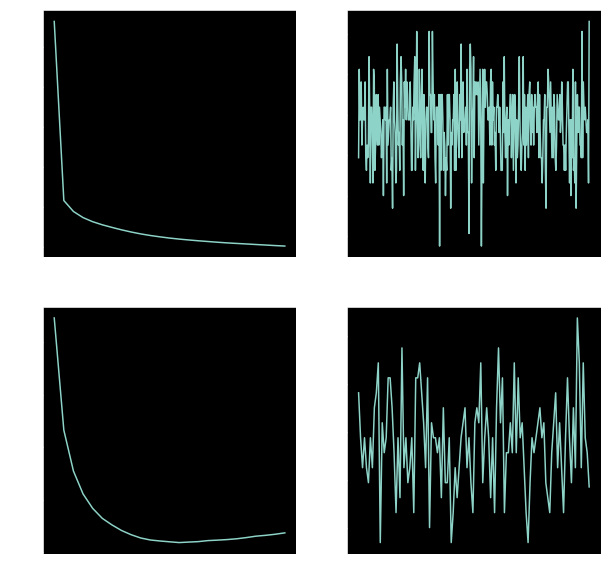

In [36]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(e_losses)
plt.subplot(222)
plt.plot(e_acc)
plt.subplot(223)
plt.plot(val_losses)
plt.subplot(224)
plt.plot(val_acc)

# Adversary

In [ ]:
adv_df = df.copy()

In [37]:
adv_df.drop("Gender_Female", axis=1, inplace=True)
adv_df.drop("Gender_Male", axis=1, inplace=True)

In [38]:
advX_train, advX_test, a_train, a_test = train_test_split(
    adv_df, sensitive_all, test_size=0.25, stratify=sensitive_all, random_state=rs,
)

In [39]:
a_train.shape

(22621,)

In [40]:
input_size = advX_train.shape[1]
adversary = SingleNet(input_size)
advopt = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
advcriterion = nn.BCELoss()

In [41]:
if torch.cuda.is_available():
    device="cuda"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device="cpu"
    torch.set_default_tensor_type('torch.FloatTensor')

In [42]:
advTrain_losses = []
advTrain_accs = []
advVal_losses = []
advVal_accs = []
num_epochs = 25
for e in range(num_epochs):
    advTrain_loss, advTrain_acc = train_epoch(adversary, advX_train, a_train, advopt, advcriterion)
    print('Epoch: {} Loss: {} Accuracy: {}'.format(e, np.mean(advTrain_loss), np.mean(advTrain_acc)))
    advTrain_losses.append(np.mean(advTrain_loss))
    advTrain_accs.append(np.mean(advTrain_acc))
    advVal_loss, advVal_acc = validate_epoch(adversary, advX_test, a_test, advcriterion)
    print('Test Epoch: {} Loss: {} Accuracy: {}'.format(e, np.mean(advVal_loss), np.mean(advVal_acc)))
    advVal_losses.append(np.mean(advVal_loss))
    advVal_accs.append(np.mean(advVal_acc))

/Users/var/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/Users/var/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/Users/var/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size())

Epoch: 0 Loss: 0.4974806469544179 Accuracy: 0.7420977011494253
Test Epoch: 0 Loss: 0.3496308100678153 Accuracy: 0.8335440318196355
Epoch: 1 Loss: 0.3204945838973347 Accuracy: 0.8427774327878435
Test Epoch: 1 Loss: 0.30440063218949204 Accuracy: 0.8476075311800447
Epoch: 2 Loss: 0.2978754339497642 Accuracy: 0.8487011128969413
Test Epoch: 2 Loss: 0.29551955703961647 Accuracy: 0.8491965142308923
Epoch: 3 Loss: 0.29181375005150917 Accuracy: 0.8500252654393141
Test Epoch: 3 Loss: 0.29269135579214256 Accuracy: 0.8497261752478413
Epoch: 4 Loss: 0.2891705152341875 Accuracy: 0.8503783727839469
Test Epoch: 4 Loss: 0.2915052491224418 Accuracy: 0.8498585905020787
Epoch: 5 Loss: 0.2876675355400743 Accuracy: 0.8507314801285797
Test Epoch: 5 Loss: 0.29089744957321784 Accuracy: 0.8490640989766549
Epoch: 6 Loss: 0.28672547491088424 Accuracy: 0.8502018191116305
Test Epoch: 6 Loss: 0.2905050221893747 Accuracy: 0.8492239966421491
Epoch: 7 Loss: 0.28605804996470274 Accuracy: 0.8508638953828169
Test Epoch: 7

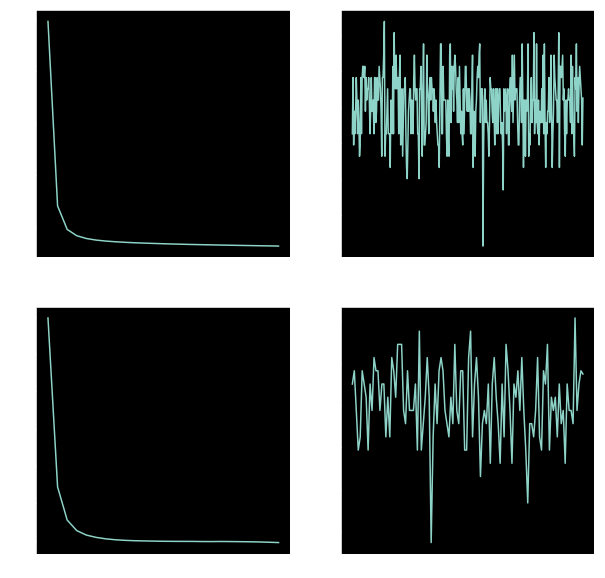

In [43]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(advTrain_losses)
plt.subplot(222)
plt.plot(advTrain_acc)
plt.subplot(223)
plt.plot(advVal_losses)
plt.subplot(224)
plt.plot(advVal_acc)

# Adv losses

In [248]:
class AdvDemographicParityLoss(nn.Module):
    def __init__(self):
        super(AdvDemographicParityLoss, self).__init__()
        self.L1_distance = nn.L1Loss()
        
    def forward(self, input, sensitive):
        if not (sensitive.shape[0] == input.shape[0]):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))
        
        if isinstance(sensitive, np.ndarray):
            sensitive = torch.from_numpy(sensitive)
            sensitive = sensitive.float()
        
        input = input.squeeze(dim=1)
        
        a0_mask = (sensitive == 0)
        a1_mask = (sensitive == 1)
        
        input_group0 = input[a0_mask]
        input_group1 = input[a1_mask]
        
        target_group0 = sensitive[a0_mask]
        target_group1 = sensitive[a1_mask]
        
        loss = 1 - (self.L1_distance(input_group0, target_group0) + self.L1_distance(input_group1, target_group1))
        return loss
        
    

In [249]:
class AdvEqOddsLoss(nn.Module):
    def __init__(self):
        super(AdvEqOddsLoss, self).__init__()
        self.L1_distance = nn.L1Loss()
        
    def forward(self, input, sensitive, targets):
        if not (targets.shape[0] == input.shape[0]):
            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))
        
        if isinstance(targets, np.ndarray):
            targets = torch.from_numpy(targets)
            targets = targets.float()
            
        if isinstance(sensitive, np.ndarray):
            sensitive = torch.from_numpy(sensitive)
            sensitive = sensitive.float()
        
        
        input = input.squeeze(dim=1)
        
        a00_mask = ((targets == 0).byte() & (sensitive == 0).byte())
        a01_mask = ((targets == 1).byte() & (sensitive == 0).byte())
        a10_mask = ((targets == 0).byte() & (sensitive == 1).byte())
        a11_mask = ((targets == 1).byte() & (sensitive == 1).byte())

        input_group00 = input[a00_mask]
        input_group01 = input[a01_mask]
        input_group10 = input[a10_mask]
        input_group11 = input[a11_mask]

        target_group00 = targets[a00_mask]
        target_group01 = targets[a01_mask]
        target_group10 = targets[a10_mask]
        target_group11 = targets[a11_mask]

        loss = 2 - (L1_distance(input_group00, target_group00) + L1_distance(input_group01, target_group01)
                   + L1_distance(input_group10, target_group10) + L1_distance(input_group11, target_group11))
    
        return loss

In [250]:
input = adversary(torch.from_numpy(advX_test.values).float())
targets = a_test

In [251]:
AdvDPLoss = AdvDemographicParityLoss()

In [252]:
AdvDPLoss(input, targets)

tensor(0.5580)

In [253]:
AdvEOLoss = AdvEqOddsLoss()

In [254]:
AdvEOLoss(input, a_test, y_test)

tensor(1.00000e-02 *
       -1.5772)